# Classification problem? 
NN, XGBoost, Random Forest, SVC, Logistic Regression


## Thinking chain

### 1. Model 
- it's binary classification problem, democrate/republic
- Two mandatory methods => __init__(define layers) & forward(define how data flow - aka activation function?).
- for the layers, proposed archs: (16->7->1) forcing the model to produce more compact representations || (16->32->1) giving the model more learning capacity! => after cleaning the data, proposed arch: (14->8->1).
- yet, there ain't much to learn in this problem, so we're sticking to the small simple network.
- the accuracy in small nn is great, then the dataset cleaning was effecient, now to simpler models!
- trying Random forest, logistic regression, SVM, XGBoost.
- good accuracy too! => cross val + finetuning tho.
### 2. Loss Function for NN
- loss function then would be Binary Cross Entropy
- if we got sigmoid in output layer => nn.BCE()
- if we don't => nn.BCEWithLogitsLoss() => BCE + sigmoid(more stable?)
### 3. Data
- gotta encode all txt data t feed em to the model
- ('y' => 0, 'n' => 1) => (df.replace({'y': 0, 'n': 1}))
- ('democrate' => 0, 'republic' => 1) => (LabelEncoder.fit_transform(df['Party']))
- Missing values: can't use mean of data as it's 0,1 => 0.5? nah; gotta use mode(df.replace('?', df.mode.iloc[0])); orrrrr make it category on its own(0, 1, 2)?
- inconsistent labels for 'democrates' and 'republicans' => lower cases + replace
### 4. Optimizer
- Adam => adapting learning rates.
- yetttt, it's small dataset, maybe simpler optimizer like SGD?

In [1]:
import warnings
warnings.filterwarnings('ignore')
rand=42 #was 305 but for some reason after performing well, it turned upon
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC #as we're classifying
from xgboost import XGBClassifier
# for the model enhancement
from sklearn.ensemble import VotingClassifier, StackingClassifier, GradientBoostingClassifier

# for the measurements + data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# for the model enhancement
from sklearn.feature_selection import SelectKBest, mutual_info_classif


## Data

### Data seperation

In [2]:
# data frame t handle the ds
df = pd.read_csv('F:/repos/DEPI/ML/Tasks/data/house-votes-84.csv')

print(f"\nhead: \n{df.head()}\n")
print(f"\n\ninfo: \n{df.info()}\n")
print(f"\n\ndescription: \n{df.describe()}")



head: 
        Party  Handicapped-infants Water-project-cost-sharing  \
0         REP                  NaN                          y   
1  Republican                  NaN                          y   
2         DEM                  NaN                          y   
3         DEM                  NaN                          y   
4         NaN                  NaN                        NaN   

  Adoption-of-the-budget-resolution Physician-fee-freeze El-salvador-aid  \
0                                 n                    y               y   
1                                 n                    y               y   
2                                 y                    ?               y   
3                                 y                    n               ?   
4                               NaN                  NaN             NaN   

  Religious-groups-in-schools Anti-satellite-test-ban  \
0                           y                       n   
1                           y 

In [3]:
df = df.dropna(how='all')
df = df.dropna(subset=['Party']) #drop rows that have no party val

#### Data observations
- Handicapped-infants has only 25 non-null values, could be dropped as it's only 5% of the data?
- Party has different labelling for the same class(mosiba D:)
- Crime col is alllll null
- numeric vals as placeholder for null aka == ? => hense the mean = -998.-- => sooo, replace with nan

### Data Visualization

In [4]:
df_vis = df.copy()
df_vis['Party'] = df_vis['Party'].str.lower()
df_vis['Party'] = df_vis['Party'].replace({
    'rep': 'republican',
    'repub': 'republican', 
    'dem': 'democrat',
    'demo': 'democrat'
})

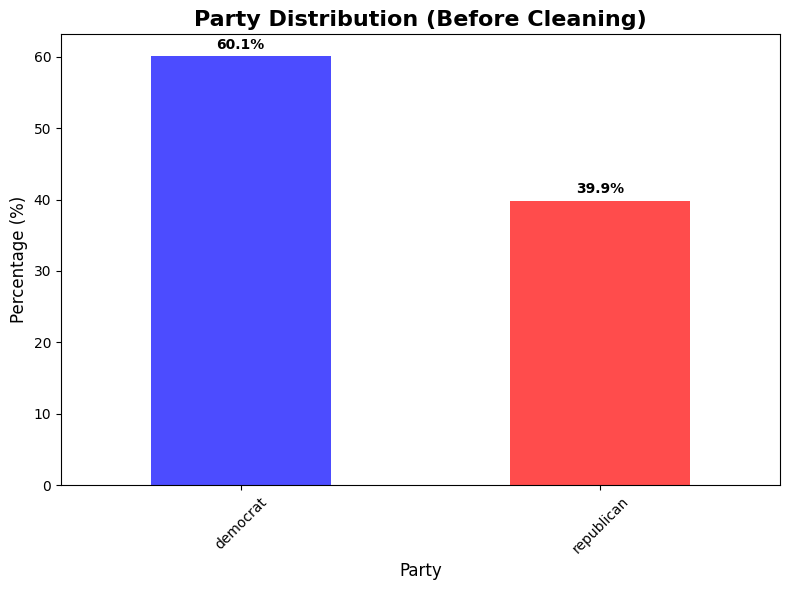


Party Distribution:
Party
democrat      60.144928
republican    39.855072
Name: proportion, dtype: float64


In [5]:
plt.figure(figsize=(8, 6))
party_counts = df_vis['Party'].value_counts(normalize=True) * 100

# Create bar chart
party_counts.plot(kind='bar', color=['blue', 'red'], alpha=0.7)
plt.title('Party Distribution (Before Cleaning)', fontsize=16, fontweight='bold')
plt.xlabel('Party', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45)

# Add percentage labels on bars
for i, v in enumerate(party_counts):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nParty Distribution:")
print(party_counts)

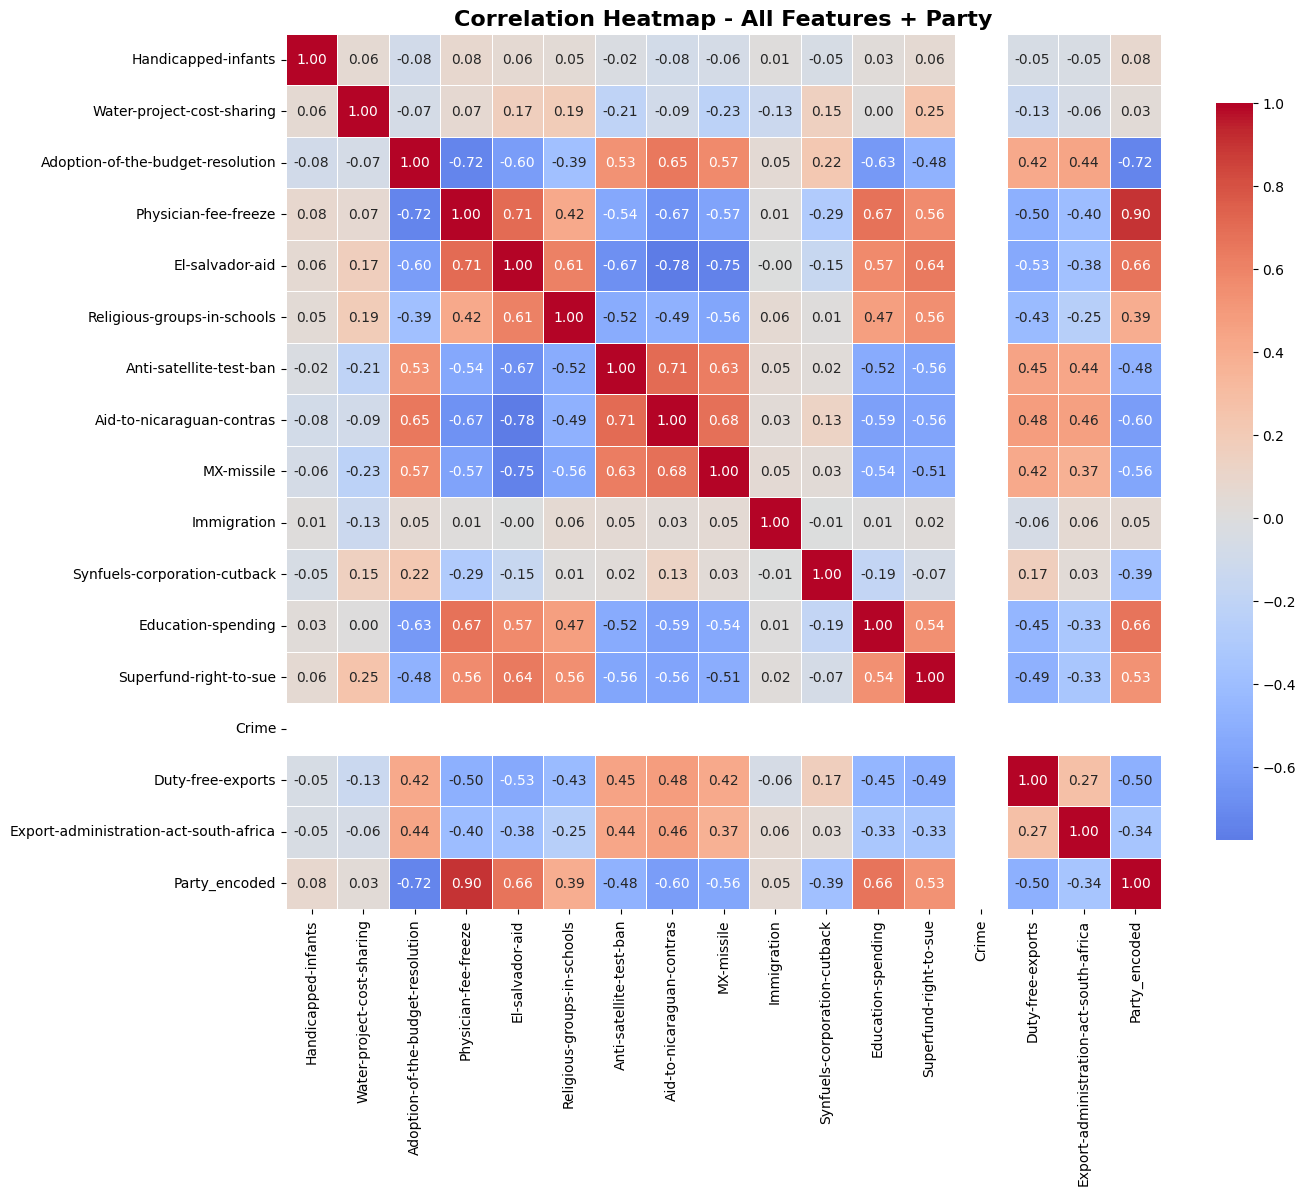


Features most correlated with Party:
Party_encoded                             1.000000
Physician-fee-freeze                      0.896065
Education-spending                        0.664357
El-salvador-aid                           0.660608
Superfund-right-to-sue                    0.528499
Religious-groups-in-schools               0.390790
Handicapped-infants                       0.083686
Immigration                               0.050429
Water-project-cost-sharing                0.031207
Export-administration-act-south-africa   -0.341887
Synfuels-corporation-cutback             -0.387222
Anti-satellite-test-ban                  -0.477483
Duty-free-exports                        -0.497214
MX-missile                               -0.556801
Aid-to-nicaraguan-contras                -0.602894
Adoption-of-the-budget-resolution        -0.722617
Crime                                          NaN
Name: Party_encoded, dtype: float64


In [6]:
# Encoding on the way
df_vis = df_vis.replace({'y': 1, 'n': 0, '?': np.nan})
df_vis = df_vis.fillna(df_vis.mode().iloc[0])

le_party = LabelEncoder()
df_vis['Party_encoded'] = le_party.fit_transform(df_vis['Party'])
y = df_vis['Party_encoded']

# correlation matrix (exclude the string 'Party' column)
correlation_matrix = df_vis.drop('Party', axis=1).corr()

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, 
            annot=True,  
            fmt='.2f',   
            cmap='coolwarm',  
            center=0,   
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap - All Features + Party', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#most correlated with Party
print("\nFeatures most correlated with Party:")
party_correlations = correlation_matrix['Party_encoded'].sort_values(ascending=False)
print(party_correlations)

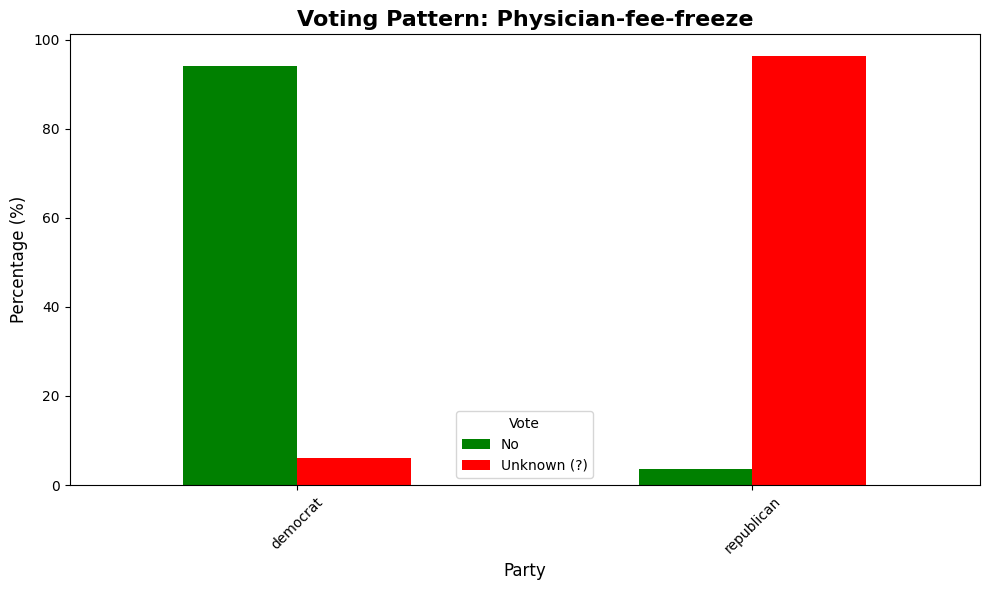


Voting patterns for Physician-fee-freeze:
Physician-fee-freeze        0.0        1.0
Party                                     
democrat              93.975904   6.024096
republican             3.636364  96.363636


In [7]:
# vote patterns
voting_col = 'Physician-fee-freeze'  

#raw votes ('y', 'n', '?') grouped by party
df_voting = df_vis[[voting_col, 'Party']].copy()

#counts of y/n/? for each party
vote_counts = pd.crosstab(df_voting['Party'], df_voting[voting_col], normalize='index') * 100

# Plot grouped bar chart
vote_counts.plot(kind='bar', figsize=(10, 6), color=['green', 'red', 'gray'])
plt.title(f'Voting Pattern: {voting_col}', fontsize=16, fontweight='bold')
plt.xlabel('Party', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Vote', labels=['No', 'Unknown (?)', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nVoting patterns for {voting_col}:")
print(vote_counts)

### Cleaning

##### Party

In [8]:
# Party different names
df['Party'] = df['Party'].str.lower().replace({
    'rep': 'republican',
    'repub': 'republican',
    'dem': 'democrat',
    'demo': 'democrat'
})

df = df.dropna(subset=['Party'])
print(df['Party'].unique())

['republican' 'democrat']


##### Crime & Handicapped-infants Dropping

In [9]:
df = df.drop('Crime', axis=1) #axis=1 aka col, 0 aka row
df = df.drop('Handicapped-infants', axis=1)
df.head()

,Party,Water-project-cost-sharing,Adoption-of-the-budget-resolution,Physician-fee-freeze,El-salvador-aid,Religious-groups-in-schools,Anti-satellite-test-ban,Aid-to-nicaraguan-contras,MX-missile,Immigration,Synfuels-corporation-cutback,Education-spending,Superfund-right-to-sue,Duty-free-exports,Export-administration-act-south-africa
0,republican,y,n,y,y,y,n,n,n,y,?,y,y,n,y
1,republican,y,n,y,y,y,n,n,n,n,n,y,y,n,?
2,democrat,y,y,?,y,y,n,n,n,n,y,n,y,n,n
3,democrat,y,y,n,?,y,n,n,n,n,y,n,y,n,y
5,democrat,y,y,n,y,y,n,n,n,n,n,n,y,y,y


In [10]:
df = df.replace({'y': 1, 'n': 0, '?': np.nan})
lbl_e = LabelEncoder()
df['Party_encoded'] = lbl_e.fit_transform(df['Party'])

##### Numeric vals -999

In [11]:
df = df.fillna(df.mode().iloc[0])
# replace all placeholders with NaN
df = df.replace(-999, np.nan)
df = df.replace(to_replace=r'^-998.*', value=np.nan, regex=True) # regex replacing all ^ starting w - exact 988.--- vals
df = df.replace(to_replace=r'^-99.*', value=np.nan, regex=True) # regex replacing all ^ starting w - exact 99.--- vals

In [12]:
for col in df.columns:
    if col not in ['Party', 'Party_encoded']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col].clip(0,1)
        df.loc[df[col] <0, col] = np.nan
        mode_val = df[col].mode()
        df[col].fillna(mode_val.iloc[0], inplace=True)

print(f"NaN values after imputation: {df.isnull().sum().sum()}")
# ensuring pandas sees them all as numerics => if couldn't parse => Nan
# just as safety check

NaN values after imputation: 0


In [13]:
# Dropping cols with low var -only keeps uniqueness >1 cols:
df = df.loc[:, df.nunique() > 1]

In [14]:
print(df.dtypes)

Party                                      object
Water-project-cost-sharing                float64
Adoption-of-the-budget-resolution         float64
Physician-fee-freeze                      float64
El-salvador-aid                           float64
Religious-groups-in-schools               float64
Anti-satellite-test-ban                   float64
Aid-to-nicaraguan-contras                 float64
MX-missile                                float64
Immigration                               float64
Synfuels-corporation-cutback              float64
Education-spending                        float64
Superfund-right-to-sue                    float64
Duty-free-exports                         float64
Export-administration-act-south-africa    float64
Party_encoded                               int64
dtype: object


### Splitting

In [15]:
# make sure u has a numpy-like shape attribute
y = df['Party_encoded']
X = df.drop(['Party','Party_encoded'], axis=1)
y = np.asarray(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand, stratify=y)
#stratify =y to maintain class distribution in train and test sets? 
# ensure train,test have same portion of dem/rep as original portion in y!

print(f"train: X={X_train.shape}, y={y_train.shape}")
print(f"test: X={X_test.shape}, y={y_test.shape}")
print(y)


train: X=(331, 14), y=(331,)
test: X=(83, 14), y=(83,)
[1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0
 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1
 1 1 0 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0
 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0
 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0
 0 0 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1
 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1
 0 1 0 1 0 0 0]


In [16]:
print("=" * 50)
print("FINAL DATA CHECK")
print("=" * 50)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {pd.isna(y).sum()}")
print(f"Target classes: {np.unique(y)}")
print(f"Feature columns: {list(X.columns)}")
print("=" * 50)

FINAL DATA CHECK
Features shape: (414, 14)
Target shape: (414,)
Missing values in X: 0
Missing values in y: 0
Target classes: [0 1]
Feature columns: ['Water-project-cost-sharing', 'Adoption-of-the-budget-resolution', 'Physician-fee-freeze', 'El-salvador-aid', 'Religious-groups-in-schools', 'Anti-satellite-test-ban', 'Aid-to-nicaraguan-contras', 'MX-missile', 'Immigration', 'Synfuels-corporation-cutback', 'Education-spending', 'Superfund-right-to-sue', 'Duty-free-exports', 'Export-administration-act-south-africa']


In [17]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')

# Direct DataFrame creation
X_train = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("\n" + "=" * 50)
print("AFTER IMPUTATION - FINAL DATA CHECK")
print("=" * 50)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"NaN in X_train: {X_train.isnull().sum().sum()}")
print(f"NaN in X_test: {X_test.isnull().sum().sum()}")
print("=" * 50)


AFTER IMPUTATION - FINAL DATA CHECK
Train shape: (331, 14)
Test shape: (83, 14)
NaN in X_train: 0
NaN in X_test: 0


#### Notes
- now our data moved from 457 => 414? cus we dropped all the rows missing Party labels.
- cols- 17 => 14 + 1 target = 15? dropped Crime(all Nan), dropped Handicapped-infants(not that useful)

## Model

### Simple-ANN as higher base mark


- change data format to Tensor in order to use PyTorch; we finished all the data processing on pandas' data frames, now to tensors.
- so, we go to int or float? => NN loves floating point math.

In [18]:
X_train_tens = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tens = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tens = torch.tensor(y_train, dtype=torch.float32)
y_test_tens = torch.tensor(y_test, dtype=torch.float32)

#### Arch
- now we got 14 features, then our modified arch: (14->8->1)
- activation in hidden => ReLU; output BCEWL

In [19]:
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size =14, hidden=8, lr=0.001):
        super(NeuralNetClassifier, self).__init__()

        self.input = nn.Linear(input_size,hidden)
        self.output = nn.Linear(hidden,1)
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)


    def forward(self, x):
        x = torch.relu(self.input(x))
        x = self.output(x)
        return x
    
    def fit(self, x_train, y_train, epochs=100, batch_size=32, verbos=True): #verbos: print training progress
        for epoch in range(epochs):
            # 1. trainning mode.
            self.train()
            
            #2. Mini-Batching
            for i in range(0, len(x_train), batch_size):
                X_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # a. forward pass
                out = self.forward(X_batch).squeeze() #rmv the batch dim (331, 1) => (331,)

                # b. loss
                loss = self.criterion(out, y_batch)

                # c. zero grad => to not accumulate by def
                self.optimizer.zero_grad()

                # d. backward gradient
                loss.backward()

                # e. update weight
                self.optimizer.step()


            if verbos and (epoch + 1) % 10 == 0:
                print(f"epoch [{epoch+1}/{epochs}], loss: {loss.item():.4f}")

        return self
        
    def predict(self, X):
         #1. set Eval mode
        self.eval()
        with torch.no_grad():
            out = self.forward(X).squeeze()

            probs = torch.sigmoid(out).numpy()

        return (probs > 0.5).astype(int)
    
    def score(self, X, y):
        
        if isinstance(y, torch.Tensor):
            y = y.numpy()

        pred = self.predict(X)
        acc = (pred == y).mean()
        return acc

#### Testing
- merely for testing if i got lucky with the splits and got high accuracy in the model or it's really working :>

In [20]:
nn_model = NeuralNetClassifier(input_size=14, hidden=8, lr=0.001)
nn_model.fit(X_train_tens, y_train_tens, epochs=200, batch_size=32)

nn_train_acc = nn_model.score(X_train_tens, y_train_tens)
nn_test_acc = nn_model.score(X_test_tens, y_test_tens)

print(f"\nNeural Network Results:")
print(f"  Train Accuracy: {nn_train_acc * 100:.2f}%")
print(f"  Test Accuracy: {nn_test_acc * 100:.2f}%")

epoch [10/200], loss: 0.5363
epoch [20/200], loss: 0.3072
epoch [30/200], loss: 0.1943
epoch [40/200], loss: 0.1423
epoch [50/200], loss: 0.1169
epoch [60/200], loss: 0.1030
epoch [70/200], loss: 0.0950
epoch [80/200], loss: 0.0906
epoch [90/200], loss: 0.0889
epoch [100/200], loss: 0.0880
epoch [110/200], loss: 0.0878
epoch [120/200], loss: 0.0877
epoch [130/200], loss: 0.0878
epoch [140/200], loss: 0.0882
epoch [150/200], loss: 0.0887
epoch [160/200], loss: 0.0885
epoch [170/200], loss: 0.0888
epoch [180/200], loss: 0.0890
epoch [190/200], loss: 0.0892
epoch [200/200], loss: 0.0893

Neural Network Results:
  Train Accuracy: 96.68%
  Test Accuracy: 97.59%


### Simpler Models Comparison
- to get back t simpler models, they need numpy arrays or pandas dataframes

In [21]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print(f"{name}: {score * 100:.2f}\n")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=['Democrat', 'Republican']))
    scores = cross_val_score(model, X, y, cv=5)
    print(f"mean cv score: {scores.mean() *100:.2f}%\n\n\n")

Logistic Regression: 97.59

              precision    recall  f1-score   support

    Democrat       0.98      0.98      0.98        50
  Republican       0.97      0.97      0.97        33

    accuracy                           0.98        83
   macro avg       0.97      0.97      0.97        83
weighted avg       0.98      0.98      0.98        83

mean cv score: 95.15%



Random Forest: 96.39

              precision    recall  f1-score   support

    Democrat       1.00      0.94      0.97        50
  Republican       0.92      1.00      0.96        33

    accuracy                           0.96        83
   macro avg       0.96      0.97      0.96        83
weighted avg       0.97      0.96      0.96        83

mean cv score: 95.64%



SVM: 95.18

              precision    recall  f1-score   support

    Democrat       0.98      0.94      0.96        50
  Republican       0.91      0.97      0.94        33

    accuracy                           0.95        83
   macro avg    

#### Tuning

In [22]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

print("\nRandom Forest tune:")
rf = RandomForestClassifier(random_state=rand)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train, y_train)

#print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_ * 100:.2f}%")
print(f"Test accuracy: {rf_grid.score(X_test, y_test) * 100:.2f}%")

# Let's also tune XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.3]
}

print("\nXGBoost tune:")
xgb = XGBClassifier(random_state=rand, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

#print(f"Best parameters: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_ * 100:.2f}%")
print(f"Test accuracy: {xgb_grid.score(X_test, y_test) * 100:.2f}%")


Random Forest tune:
Best CV score: 96.68%
Test accuracy: 96.39%

XGBoost tune:
Best CV score: 95.17%
Test accuracy: 96.39%


## Enhancment

In [23]:
#1. Feature Importance Analysis
mi_scores = mutual_info_classif(X_train, y_train, random_state=rand)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': mi_scores
}).sort_values('importance', ascending=False) 
#as to select the most importatn ones later and discard the rest
print(f"top 10 important features:{feature_importance.head(10).to_string(index=False)}")

top 10 important features:                          feature  importance
             Physician-fee-freeze    0.475989
Adoption-of-the-budget-resolution    0.303548
               Education-spending    0.273164
                  El-salvador-aid    0.243447
        Aid-to-nicaraguan-contras    0.201733
                       MX-missile    0.168792
           Superfund-right-to-sue    0.154235
                Duty-free-exports    0.141209
          Anti-satellite-test-ban    0.136415
      Religious-groups-in-schools    0.123501


In [24]:
# 2. Stacking Ensemble
base = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=rand)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, 
                          random_state=rand, eval_metric='logloss')),  
    ('svm', SVC(kernel='rbf', C=10, probability=True, random_state=rand)),
('lr', LogisticRegression(max_iter=1000))  # Added for diversity
]

stack_cls = StackingClassifier(
    estimators=base,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stack_cls.fit(X_train, y_train)
stack_test = stack_cls.score(X_test, y_test)
stack_cv = cross_val_score(stack_cls, X, y, cv=5, scoring='accuracy')

print(f"acc: {stack_test * 100:.2f}%")
print(f"CV Score: {stack_cv.mean() * 100:.2f}% (+/- {stack_cv.std() * 100:.2f}%)")

acc: 97.59%
CV Score: 95.40% (+/- 1.44%)


In [25]:
# 3. Voting Classifier
voting_cls = VotingClassifier(estimators=base, voting='soft', weights=[2, 3, 1, 1])
voting_cls.fit(X_train, y_train)
voting_test = voting_cls.score(X_test, y_test)
voting_cv = cross_val_score(voting_cls, X, y, cv=5, scoring='accuracy')

print(f"acc: {voting_test * 100:.2f}%")
print(f"CV Score: {voting_cv.mean() * 100:.2f}% (+/- {voting_cv.std() * 100:.2f}%)")

acc: 96.39%
CV Score: 95.16% (+/- 1.35%)


In [26]:
# 4. Feature Selection + Optimized Model
selector = SelectKBest(mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()].tolist()
print(f"Selected Features: {selected_features}")

xgb_optimized = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                               random_state=rand, eval_metric='logloss')  # Removed deprecated parameter
xgb_optimized.fit(X_train_selected, y_train)
optimized_test = xgb_optimized.score(X_test_selected, y_test)

print(f"Test Accuracy: {optimized_test * 100:.2f}%")

Selected Features: ['Adoption-of-the-budget-resolution', 'Physician-fee-freeze', 'El-salvador-aid', 'Religious-groups-in-schools', 'Anti-satellite-test-ban', 'Aid-to-nicaraguan-contras', 'MX-missile', 'Education-spending', 'Superfund-right-to-sue', 'Duty-free-exports']
Test Accuracy: 93.98%


Training Logistic Regression... ✓
Training Tuned Random Forest... ✓
Training Tuned XGBoost... ✓
Training Gradient Boosting... ✓
Training Stacking Ensemble... ✓
Training Voting Ensemble... ✓
performance report


Logistic Regression       │ Test: 97.59% │ CV: 95.15% ± 3.10% │
Stacking Ensemble         │ Test: 97.59% │ CV: 95.40% ± 1.44% │
Voting Ensemble           │ Test: 96.39% │ CV: 95.16% ± 1.35% │
Tuned XGBoost             │ Test: 96.39% │ CV: 94.20% ± 1.63% │
Tuned Random Forest       │ Test: 95.18% │ CV: 95.16% ± 2.57% │
Gradient Boosting         │ Test: 95.18% │ CV: 94.92% ± 1.81% │

Best Model: Logistic Regression (97.59%)
Second: Stacking Ensemble (97.59%)
Third: Voting Ensemble (96.39%)

CONFUSION MATRICES - TOP 3 MODELS


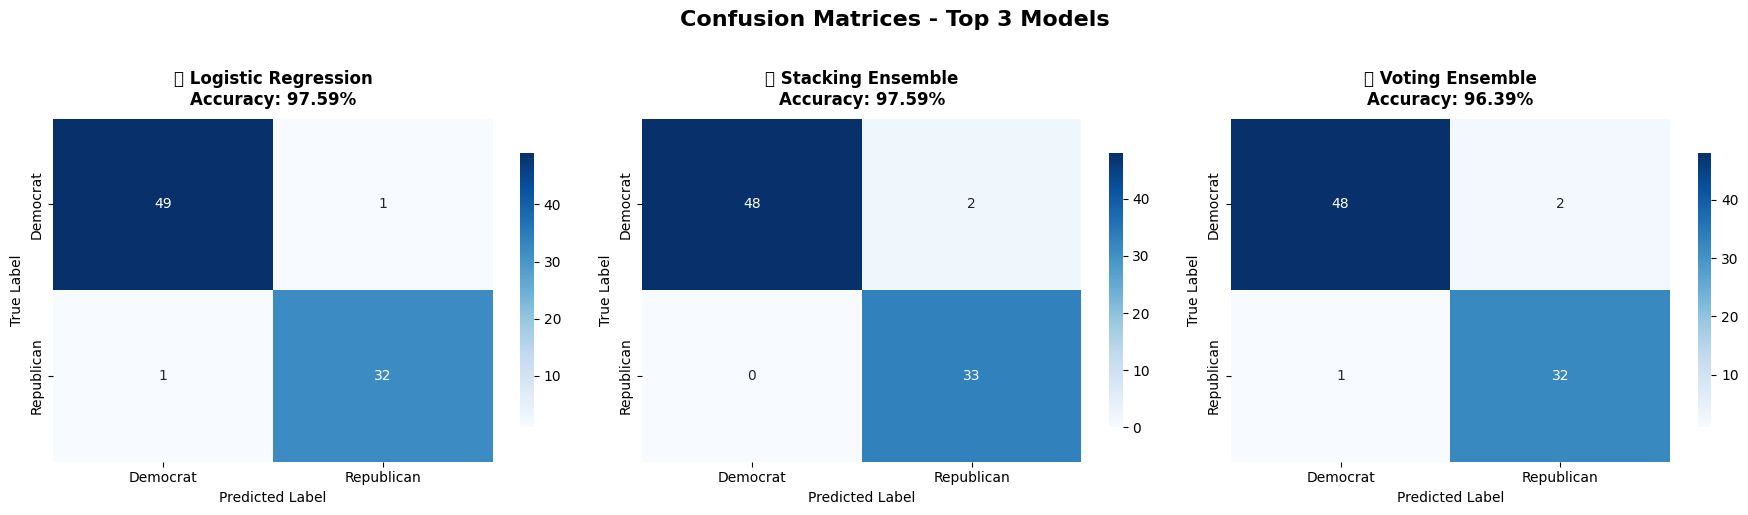

In [27]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Tuned Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=rand),
    'Tuned XGBoost': XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.1,
                                      random_state=rand, eval_metric='logloss'),  
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=rand),
    'Stacking Ensemble': stack_cls,
    'Voting Ensemble': voting_cls,
    }

results = []
trained_models = {}

for name, model in models.items():
    # Train model (skip NN as already trained)
    if name != 'NeuralNetClassifier':
        print(f"Training {name}...", end=" ")
        model.fit(X_train, y_train)
        print("✓")
    
    # Get predictions and scores
    if name == 'NeuralNetClassifier':
        test_acc = nn_test_acc
        y_pred = model.predict(X_test_tens)
        cv_mean = nn_test_acc  # Use test as proxy
        cv_std = 0.0
    else:
        test_acc = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    
    # Store trained model and predictions
    trained_models[name] = {'model': model, 'predictions': y_pred}
    
    results.append({
        'Model': name,
        'Test Accuracy': test_acc * 100,
        'CV Mean': cv_mean * 100 if name != 'NeuralNetClassifier' else None,
        'CV Std': cv_std * 100 if name != 'NeuralNetClassifier' else None
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)

# Results
print("performance report\n\n")

for idx, row in results_df.iterrows():
    model_name = row['Model']
    test_acc = row['Test Accuracy']
    
    # Create performance bar
    bar_length = int(test_acc / 5)
    
    if pd.notna(row['CV Mean']):
        print(f"{model_name:25s} │ Test: {test_acc:5.2f}% │ CV: {row['CV Mean']:5.2f}% ± {row['CV Std']:4.2f}% │")
    else:
        print(f"{model_name:25s} │ Test: {test_acc:5.2f}% │ CV: N/A          │")

print("="*70)

#top 3 models
top_3 = results_df.head(3)
print(f"\nBest Model: {top_3.iloc[0]['Model']} ({top_3.iloc[0]['Test Accuracy']:.2f}%)")
print(f"Second: {top_3.iloc[1]['Model']} ({top_3.iloc[1]['Test Accuracy']:.2f}%)")
print(f"Third: {top_3.iloc[2]['Model']} ({top_3.iloc[2]['Test Accuracy']:.2f}%)")


# CONFUSION MATRICES
print("\n" + "="*70)
print("CONFUSION MATRICES - TOP 3 MODELS")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - Top 3 Models', fontsize=16, fontweight='bold', y=1.02)

for idx, (ax, (_, row)) in enumerate(zip(axes, top_3.iterrows())):
    model_name = row['Model']
    y_pred = trained_models[model_name]['predictions']
    
    # Convert tensor predictions to numpy if needed
    if isinstance(y_pred, np.ndarray):
        y_pred_np = y_pred
    else:
        y_pred_np = y_pred
    
    cm = confusion_matrix(y_test, y_pred_np)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Democrat', 'Republican'],
                yticklabels=['Democrat', 'Republican'],
                cbar_kws={'shrink': 0.8})
    
    # Add medal emoji
    medals = ['🥇', '🥈', '🥉']
    ax.set_title(f'{medals[idx]} {model_name}\nAccuracy: {row["Test Accuracy"]:.2f}%', 
                 fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()